In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
from sklearn.cluster import KMeans
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.feature_extraction import *
from model_scripts.get_statistics import *
from Pipeline.pre_processing_pipeline import *
import numpy as np
import preprocessing_config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure

### Loading Train and Test Data: For ML Algorithms

Train

In [4]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
len(temporal_images), temporal_images[0][0].shape

(2425, (64, 64, 13))

In [5]:
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
len(border_removed_images_train)

2425

In [6]:
non_temporal_images = get_non_temporal_images(border_removed_images_train)
(non_temporal_images[0]).shape

(64, 64, 13)

In [7]:
# visualise_all_bands(non_temporal_images[0])

In [8]:
# non_temporal_images_norm = []
# for image in non_temporal_images:
#     non_temporal_images_norm.append(normalize_temporal_image(image))

# np.min(non_temporal_images_norm[0][:,:,1]), np.max(non_temporal_images_norm[0][:,:,1])

In [9]:
field_numbers, refined_images_train = refine_chanel_non_temporal(non_temporal_images)
len(refined_images_train)

2425

Test

In [10]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
len(temporal_images_test), temporal_images_test[0][0].shape

(48, (64, 64, 13))

In [11]:
border_removed_images = blacken_field_borders_temporal(temporal_images_test)
len(border_removed_images)

48

In [12]:
non_temporal_images_test = get_non_temporal_images(border_removed_images)
(non_temporal_images_test[0]).shape

(64, 64, 13)

In [13]:
# non_temporal_images_norm_test = []
# for image in non_temporal_images_test:
#     non_temporal_images_norm_test.append(normalize_temporal_image(image))

# np.min(non_temporal_images_norm_test[0][:,:,1]), np.max(non_temporal_images_norm_test[0][:,:,1])

In [14]:
field_numbers_test, refined_images_test = refine_chanel_non_temporal(non_temporal_images_test)
len(refined_images_test)

48

In [15]:
image_tensor_train = np.stack(refined_images_train)  # Shape: (N x 64 x 64 x 6)
image_tensor_test = np.stack(refined_images_test)   # Shape: (N x 64 x 64 x 6)

### K-means Clustering
- Flattening the data 
- Getting spatial features eg. average
- Channel-wise mean/histogram features
- Pixelwise Clustering

##### 1. Flattening the data - 46.54% - 45.9%

In [4]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)

# field_numbers, indices_images = indexbands_temporal_cubes(border_removed_images_train, 'msi')
field_numbers, indices_images = multiple_indices_bands_temporal_cubes(border_removed_images_train)
non_temporal_images = get_non_temporal_images(indices_images)
refined_images_train = non_temporal_images
len(refined_images_train), refined_images_train[0].shape

(2425, (64, 64, 8))

In [5]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
border_removed_images_test = blacken_field_borders_temporal(temporal_images_test)

# field_numbers_test, indices_images_test = indexbands_temporal_cubes(border_removed_images_test, 'msi')
field_numbers_test, indices_images_test = multiple_indices_bands_temporal_cubes(border_removed_images_test)
non_temporal_images_test = get_non_temporal_images(indices_images_test)
refined_images_test = non_temporal_images_test
(len(refined_images_test), refined_images_test[0].shape)

(48, (64, 64, 8))

In [6]:
image_tensor_train = np.stack(refined_images_train)   # Shape: (N x 64 x 64 x 6)
flattened_data_train = image_tensor_train.reshape(image_tensor_train.shape[0], -1)  # Shape: (N, 24,576)
flattened_data_train.shape

(2425, 32768)

In [7]:
image_tensor_test = np.stack(refined_images_test)   # Shape: (N x 64 x 64 x 6)
flattened_data_test = image_tensor_test.reshape(image_tensor_test.shape[0], -1)  # Shape: (N, 24,576)
flattened_data_test.shape

(48, 32768)

In [25]:
kmeans = KMeans(n_clusters=2, random_state=412)
kmeans.fit(flattened_data_train)

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=412)

In [26]:
test_cluster_labels = kmeans.predict(flattened_data_test)

In [27]:
accuracy, pred_aligned, gt_aligned = get_accuracy(field_numbers_test, test_cluster_labels, config.labels_path)
accuracy

0.41935483870967744

In [21]:
ari = adjusted_rand_score(gt_aligned, pred_aligned)
ari

0.0055416880650670615

#### 2. Average: Downscale Images - 52.45% - 49.18%

In [21]:
downscaled_images = np.array([
    skimage.measure.block_reduce(img, (8, 8, 1), np.mean) for img in refined_images_train
])  # Shape: (N, 8, 8, 6)


flattened_data_train = downscaled_images.reshape(downscaled_images.shape[0], -1)  # Shape: (N, 384)
flattened_data_train.shape

(2425, 384)

In [22]:
downscaled_images = np.array([
    skimage.measure.block_reduce(img, (8, 8, 1), np.mean) for img in refined_images_test
])  # Shape: (N, 8, 8, 6)


flattened_data_test = downscaled_images.reshape(downscaled_images.shape[0], -1)  # Shape: (N, 384)
flattened_data_test.shape

(48, 384)

In [23]:
kmeans = KMeans(n_clusters=2, random_state=4)
kmeans.fit(flattened_data_train)

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=4)

In [24]:
test_cluster_labels = kmeans.predict(flattened_data_test)

In [25]:
accuracy, pred_aligned, gt_aligned = get_accuracy(field_numbers_test, test_cluster_labels, config.labels_path)
accuracy

0.4918032786885246

In [26]:
ari = adjusted_rand_score(gt_aligned, pred_aligned)
ari

-0.016314538570865532

#### 3. Channel-level histogram features - 54.09% - 55.73%

##### Mean and STD

In [59]:
# # Compute mean and standard deviation for each channel
# aggregated_data_train = np.array([
#     [np.mean(img[:, :, i][img[:, :, i] != 0]), np.std(img[:, :, i][img[:, :, i] != 0])] 
#     for img in refined_images_train for i in range(6)
# ]).reshape(len(refined_images_train), -1)  # Shape: (N, 12)

# aggregated_data_train.shape

In [ ]:
# # Compute mean and standard deviation for each channel
# aggregated_data_test = np.array([
#     [np.mean(img[:, :, i][img[:, :, i] != 0]), np.std(img[:, :, i][img[:, :, i] != 0])] 
#     for img in refined_images_test for i in range(6)
# ]).reshape(len(refined_images_test), -1)  # Shape: (N, 12)

##### Histogram Features

In [17]:
num_bins = 256  # 256 bins for normalized float images

# Compute histogram features for each channel, excluding zero pixels
aggregated_data_train = np.array([
    # np.histogram(img[:, :, i], bins=num_bins, range=(0, 1))[0]
    np.histogram(img[:, :, i][img[:, :, i] != 0], bins=num_bins, range=(1e-6, 1))[0]  # Avoid 0
    for img in refined_images_train for i in range(6)
]).reshape(len(refined_images_train), -1) # Shape: (N, num_bins * 6)

In [18]:
num_bins = 256  # 256 bins for normalized float images

# Compute histogram features for each channel, excluding zero pixels
aggregated_data_test = np.array([
    # np.histogram(img[:, :, i], bins=num_bins, range=(0, 1))[0]
    np.histogram(img[:, :, i][img[:, :, i] != 0], bins=num_bins, range=(1e-6, 1))[0]  # Avoid 0
    for img in refined_images_test for i in range(6)
]).reshape(len(refined_images_test), -1) # Shape: (N, num_bins * 6)

In [19]:
kmeans = KMeans(n_clusters=2, random_state=17)
kmeans.fit(aggregated_data_train)

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=17)

In [20]:
test_cluster_labels = kmeans.predict(aggregated_data_test)

In [21]:
accuracy, pred_aligned, gt_aligned = get_accuracy(field_numbers_test, test_cluster_labels, config.labels_path)
accuracy

0.5483870967741935

In [22]:
ari = adjusted_rand_score(gt_aligned, pred_aligned)
ari

-0.004628632938643703

#### 4. Pixel-wise Clustering - 40.9% - 41.9%

Workflow:
1. Normalize the image pixel values channel-wise.
2. Flatten the image for pixel-level clustering.
3. Use K-Means to cluster pixels into diseased and healthy regions.
4. Aggregate pixel clusters to classify the field (image).
5. Visualize results and refine the approach.

In [18]:
image_tensor_train.shape, image_tensor_test.shape

((2425, 64, 64, 6), (48, 64, 64, 6))

In [19]:
train_images = image_tensor_train
test_images = image_tensor_test

In [20]:
non_temporal_images = np.array(non_temporal_images)             # Shape: (2425, 64, 64, 13)
non_temporal_images_test = np.array(non_temporal_images_test)   # Shape: (48, 64, 64, 13)

# Step 1: Create valid pixel masks using the second-to-last channel (-2) of non_temporal_images
train_masks = non_temporal_images[..., -2] != 0  # Shape: (2425, 64, 64)
test_masks = non_temporal_images_test[..., -2] != 0  # Shape: (48, 64, 64)


In [21]:
train_masks.shape

(2425, 64, 64)

In [22]:
train_images.shape

(2425, 64, 64, 6)

In [23]:
# Step 2: Extract valid pixels from all training images
train_valid_pixels = np.vstack([
    train_images[i][train_masks[i]] for i in range(train_images.shape[0])
])  # Shape: (num_valid_pixels_in_train, 6)

# Step 3: Extract valid pixels from all test images
test_valid_pixels = np.vstack([
    test_images[i][test_masks[i]] for i in range(test_images.shape[0])
])  # Shape: (num_valid_pixels_in_test, 6)

In [24]:
test_valid_pixels.shape

(12214, 6)

In [25]:
train_valid_pixels.shape

(539066, 6)

In [26]:
# Step 3: Perform clustering on valid pixels
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming 2 clusters
kmeans.fit(train_valid_pixels)

# Step 4: Assign cluster labels to valid pixels in training and testing images
def assign_clusters(images, masks, kmeans_model):
    clustered_images = []
    for i in range(images.shape[0]):
        valid_pixel_data = images[i][masks[i]]                          # Extract valid pixels
        
        if valid_pixel_data.shape[0]==0: 
            valid_pixel_labels = 0
        else:
            valid_pixel_labels = kmeans_model.predict(valid_pixel_data)     # Predict clusters
        clustered_image = np.zeros(images.shape[1:3], dtype=int)        # Initialize with zeros
        clustered_image[masks[i]] = valid_pixel_labels                  # Map labels to valid pixels
        clustered_images.append(clustered_image)
    return np.array(clustered_images)

# Assign clusters
train_clustered_images = assign_clusters(train_images, train_masks, kmeans)
test_clustered_images = assign_clusters(test_images, test_masks, kmeans)



/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


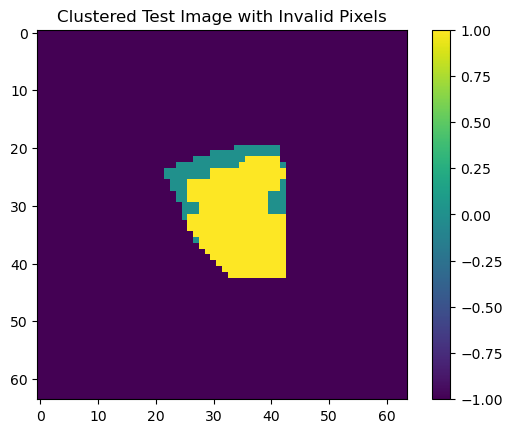

In [88]:
def visualize_with_invalid(image, mask, title="Clustered Image with Mask"):
    displayed_image = image.copy()
    displayed_image[~mask] = -1  # Assign -1 to invalid pixels
    plt.imshow(displayed_image, cmap='viridis', vmin=-1, vmax=image.max())
    plt.title(title)
    plt.colorbar()
    plt.show()

visualize_with_invalid(test_clustered_images[31], test_masks[31], "Clustered Test Image with Invalid Pixels")


In [28]:
len(field_numbers_test)

48

In [89]:
field_numbers_test[31]

'1222641.0'

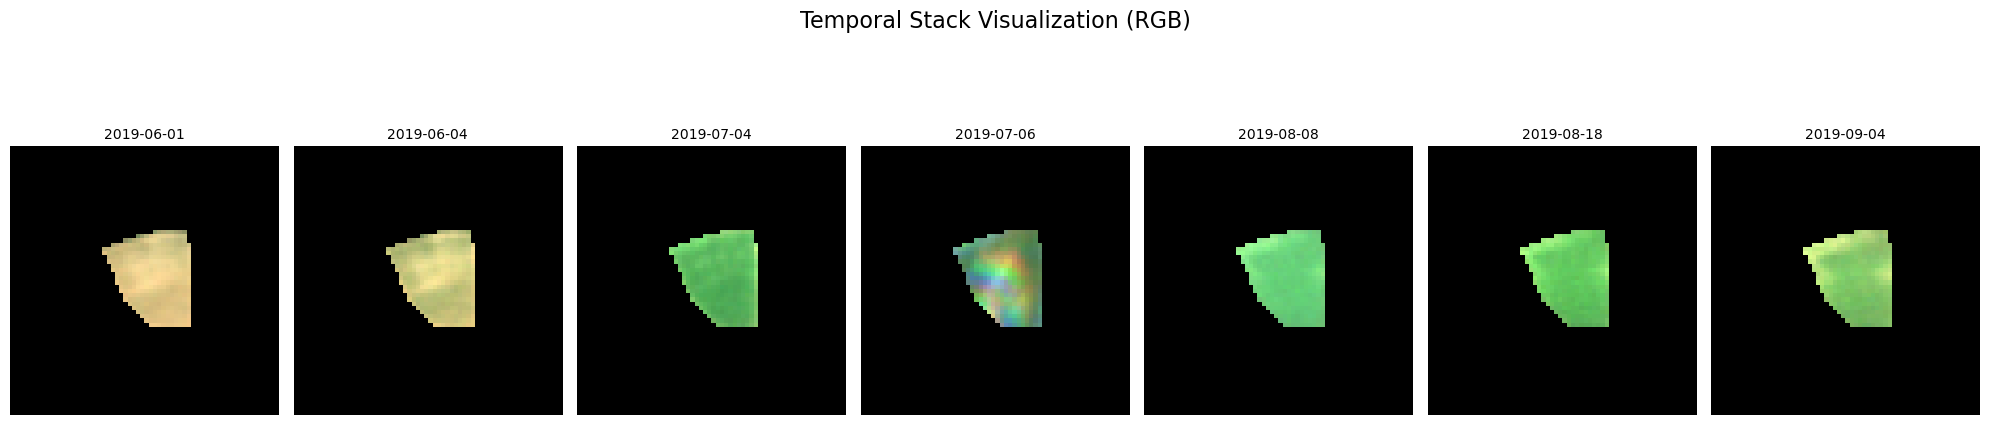

In [87]:
visualize_temporal_stack_rgb(temporal_images_test[31])

In [31]:
np.unique(temporal_images_test[39][0][:,:, -2])

array([      0., 1225592.])

No disease: 19, 23

In [32]:
np.unique(test_clustered_images[3])

array([0, 1])

In [33]:
np.unique(test_masks[0])

array([False,  True])

In [90]:
import pandas as pd
from sklearn.metrics import accuracy_score

def calculate_test_accuracy(test_images, test_masks, field_numbers_test, kmeans, csv_path):
    """
    Calculate the accuracy of test images based on k-means clustering results.
    """
    df = pd.read_csv(csv_path, sep=';')
    field_numbers = df['Number'].tolist()
    ground_truth_labels = df['Disease'].map({'yes': 'diseased', 'no': 'healthy'}).tolist()
    
    predictions = []
    
    for i in range(test_images.shape[0]):

        valid_pixels = test_images[i][test_masks[i]]
        if valid_pixels.shape[0] == 0:
            pixel_clusters = 0
        else:
            pixel_clusters = kmeans.predict(valid_pixels)
        unique_clusters = np.unique(pixel_clusters)
        if len(unique_clusters) == 1:
            predictions.append(0)  # All pixels in a single cluster
        else:
            predictions.append(1)  # Pixels in multiple clusters
    print(field_numbers_test)
    accuracy, _, _ = get_accuracy(field_numbers_test, predictions, config.labels_path)
    return accuracy, predictions


In [91]:
accuracy, predictions = calculate_test_accuracy(
    test_images=test_images,
    test_masks=test_masks,
    field_numbers_test=field_numbers_test,
    kmeans=kmeans,
    csv_path=config.labels_path
)

accuracy

['1168039.0', '1228889.0', '1168663.0_1176271.0', '1168692.0_1220431.0', '1171179.0_1222688.0', '5', '1172001.0_1225692.0', '1174805.0', '1176318.0', '1176365.0', '1177274.0', '1177490.0', '1177490.0_1183928.0', '1178038.0', '1178198.0_1225298.0', '1179855.0_1187336.0', '1182776.0', '1182822.0_1216964.0', '1183171.0', '1194806.0_1194808.0', '1196327.0', '1196347.0', '1196489.0_1196747.0', '1216230.0_1219006.0', '1216239.0', '1216250.0', '1216801.0_1216804.0', '1217032.0', '1217498.0', '1219929.0_1219932.0', '1220322.0', '1222641.0', '1223341.0', '1223970.0', '1224018.0', '1224356.0', '1225081.0', '1225397.0', '1225547.0', '1225592.0', '1226125.0', '1226225.0', '1226904.0_1227074.0', '1227071.0', '1227321.0_1229711.0', '1227495.0', '1227663.0', '1230818.0']


0.5645161290322581

In [93]:
np.unique(predictions, return_counts=True)

(array([0, 1]), array([ 8, 40]))